In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import leidenalg
import igraph as ig
from collections import defaultdict

In [2]:
filename = 'graph_full.txt'

G = nx.Graph()

with open(filename, 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()
        G.add_edge(node1, node2)

In [3]:
df = pd.read_csv('graph_collapse_nodes.txt', delimiter='\t')

node_family_dict = df.set_index('name')['fam'].to_dict()
unique_fams = set(node_family_dict.values())
print(len(unique_fams))
colors = plt.get_cmap('tab20', len(unique_fams))
fam_to_color = {cls: colors(i) for i, cls in enumerate(unique_fams)}
node_colors = [fam_to_color[node_family_dict[node]] for node in G.nodes]

14


In [4]:
components = list(nx.connected_components(G))
components.sort(key=len, reverse=True)
largest_component = components[0]
G_largest = G.subgraph(largest_component).copy()

In [5]:
G_igraph = ig.Graph.from_networkx(G_largest)
partition = leidenalg.find_partition(G_igraph, leidenalg.ModularityVertexPartition)
clusters = partition.membership
for node, cluster in zip(G_largest.nodes(), clusters):
    G_largest.nodes[node]['cluster'] = cluster

families = defaultdict(set)
for node, family in node_family_dict.items():
    families[family].add(node)

clusters_dict = defaultdict(set)
for node, cluster in zip(G_largest.nodes(), clusters):
    clusters_dict[cluster].add(node)

In [6]:
matching_clusters = []
threshold = 0.6

for cluster_nodes in clusters_dict.values():
    families_in_cluster = defaultdict(int)
    for node in cluster_nodes:
        family = node_family_dict.get(node)
        if family:
            families_in_cluster[family] += 1

    for family, count in families_in_cluster.items():
        if count / len(cluster_nodes) >= threshold:
            matching_clusters.append(cluster_nodes)
            break

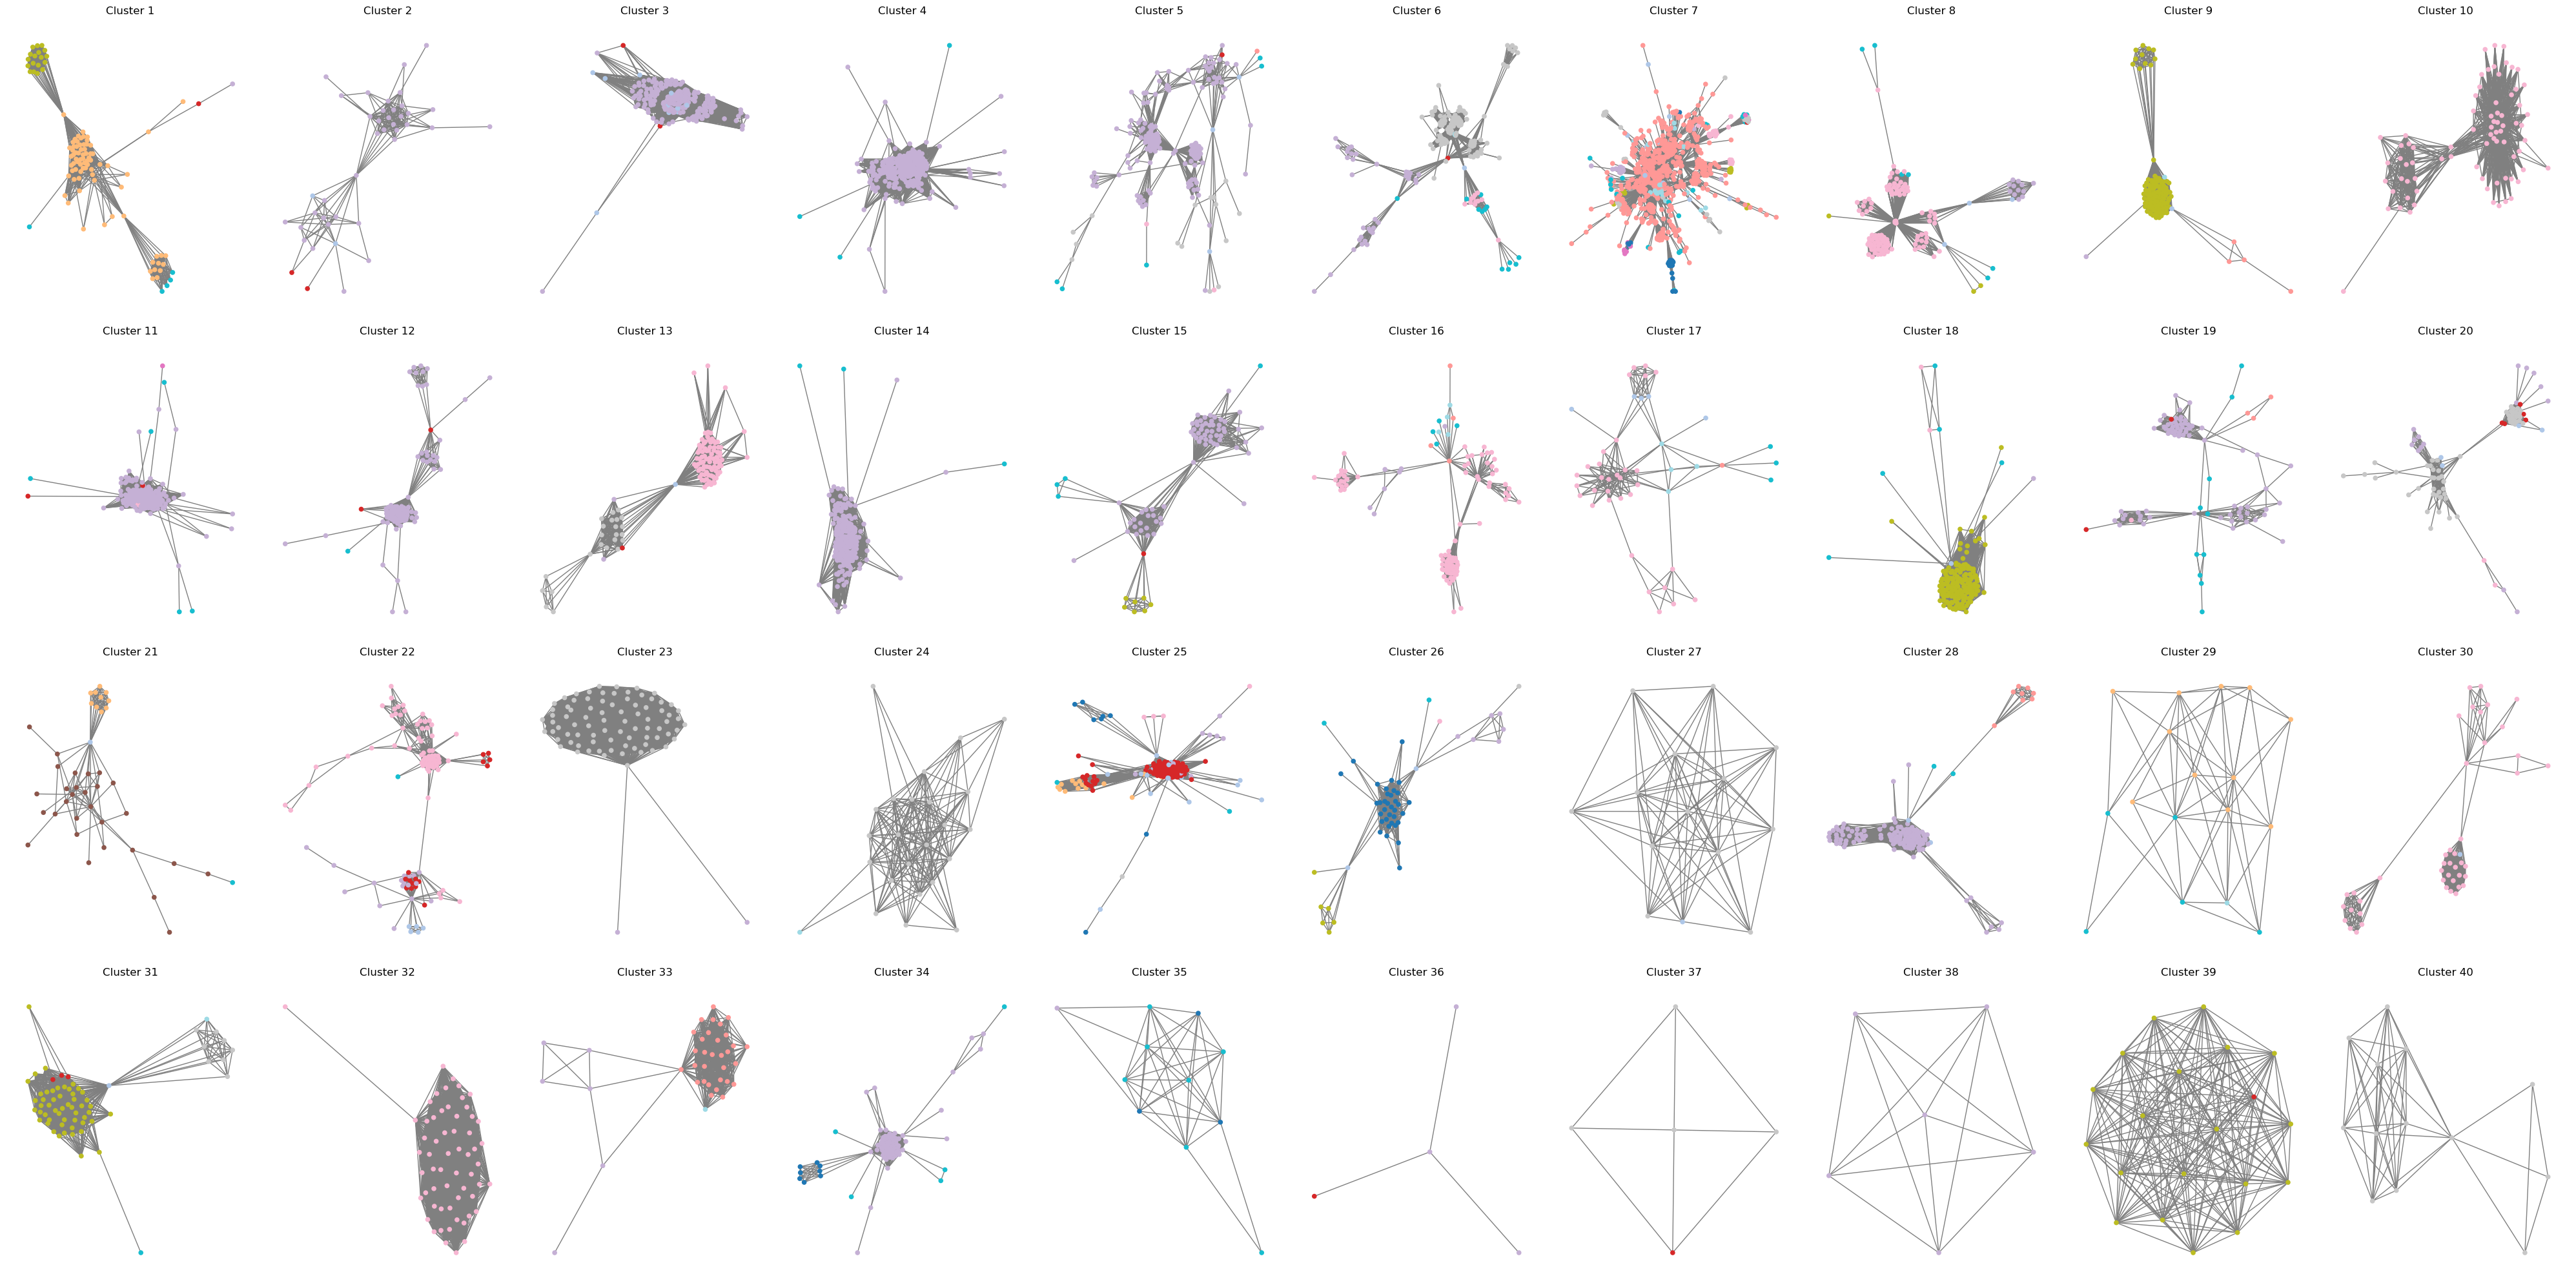

In [7]:
num_clusters = len(matching_clusters)
cols = 10
rows = (num_clusters // cols) + (num_clusters % cols > 0)

plt.figure(figsize=(40, 5 * rows))

for i, cluster_nodes in enumerate(matching_clusters):
    plt.subplot(rows, cols, i + 1)
    G_sub = G_largest.subgraph(cluster_nodes).copy()
    pos = nx.spring_layout(G_sub)
    node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]
    nx.draw(G_sub, pos, with_labels=False, node_color=node_colors_sub, edge_color='gray', node_size=20, font_size=1)
    plt.title(f'Cluster {i + 1}')

plt.tight_layout()
plt.show()